In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import math

from sklearn.metrics import r2_score

In [2]:
sns.set_theme()

# TODO !
- R2 for ID plot - Done but fix legend and axis now
- Time series plot are not very classical we need to make sure we fully understand and justify them during presentation
- Find explanation for how error bar are computed

## 1. File processing functionalities

In [3]:
# Metrics
def index_difficulty(d, w):
  return math.log2((2*d) / w)

def index_performance(id, mt):
  return id / mt

def get_id_col(df):
  return df.apply(lambda row: index_difficulty(row['A'], row['w']), axis=1)
# ============================================================================

# File reading / analysis
def get_name_device_mode(filename):
  name, a, b = filename.lower().split("/")[-1].split('_')[:3]

  # some file were named "name_device_mode" and some "name_mode_device"
  if a in ["tablet", "mouse"]:
    device = a
    mode = b
  else:
    device = b
    mode = a
  return name.capitalize(), device.capitalize(), mode.capitalize()

def analyse_file(filename):
  df = pd.read_csv(filename, skiprows=2)
  avg_click = df['clickTime'].mean()
  total_time = df['clickTime'].sum()
  errors = df['currentNumberOfErrors'].array[-1]
  name, device, mode = get_name_device_mode(filename)

  # give info for combined df
  df["device"] = device
  df["mode"] = mode

  return df, [name, device, mode, avg_click, total_time, errors]
# ============================================================================

In [4]:
# reading all csv files in "folder_name" make a table with total time / avg_click / errors
# also make combined df which contains every click data of all csv files
folder_name = 'data/'

table = []
combined_df = pd.DataFrame()
for filename in glob.glob(f'{folder_name}*.csv'):
  df, row = analyse_file(filename)
  table.append(row)
  combined_df = pd.concat([combined_df, df])

# add id metric
combined_df["ID"] = get_id_col(combined_df)

# make df from table
df = pd.DataFrame(table, columns=["Name", "Device", "Mode", "Average time", "Total time", "Errors"])

In [5]:
df.sort_values(by=["Name", "Device", "Mode"])

,Name,Device,Mode,Average time,Total time,Errors
5,Alex,Mouse,Bubble,1.125529,272.378,3
44,Alex,Mouse,Normal,1.168946,282.885,12
4,Alex,Tablet,Bubble,1.153112,279.053,35
45,Alex,Tablet,Normal,1.246343,301.615,45
27,Ana,Mouse,Bubble,1.429256,345.880,1
38,Ana,Mouse,Normal,1.238508,299.719,8
36,Ana,Tablet,Bubble,1.350161,326.739,6
18,Ana,Tablet,Normal,1.516591,367.015,33
6,Gabriel,Mouse,Bubble,1.094678,264.912,3
41,Gabriel,Mouse,Normal,1.226008,296.694,9


## 2. Initial analysis

TODO: add another plot next to the one with confidence interval that is zoomed-out

In [6]:
x_axis = [0, 7]
y_axis = [0, 1.8]
tmp = combined_df.groupby(["device", "mode", "ID"]).mean().T
extended_x = np.linspace(*x_axis, 100)

def plot_id_mt(device=["Mouse", "Tablet"], mode=["Normal", "Bubble"], legend_size=None):
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(22.5, 10.5)
  for d in device:
    for m in mode:
      x = tmp[d][m].T.index.to_numpy()
      y = tmp[d][m].T["clickTime"].to_numpy()
      ax[0].scatter(x, y, label=f"{d} {m}", alpha=0.5)
      p = np.polyfit(x, y, 1)
      sns.regplot(x=x, y=y, ax=ax[1], label=f"R² = {r2_score(y, np.polyval(p, x)):.2f}")
      print(f"{d} {m} r2: {r2_score(y, np.polyval(p, x))}")
      ax[0].plot(extended_x, np.polyval(p, extended_x), label=f"y = {p[0]:.2f}x + {p[1]:.2f}")

  ax[0].axis(x_axis + y_axis)
  for i in range(2):
    ax[i].legend(loc="lower right", fontsize=15)
    ax[i].set_xlabel("Index of Difficulty (ID)", fontsize=18)
    ax[i].set_ylabel("Movement Time (seconds)", fontsize=18)
  plt.show()

Mouse Normal r2: 0.9490356087924564
Mouse Bubble r2: 0.899465619874181


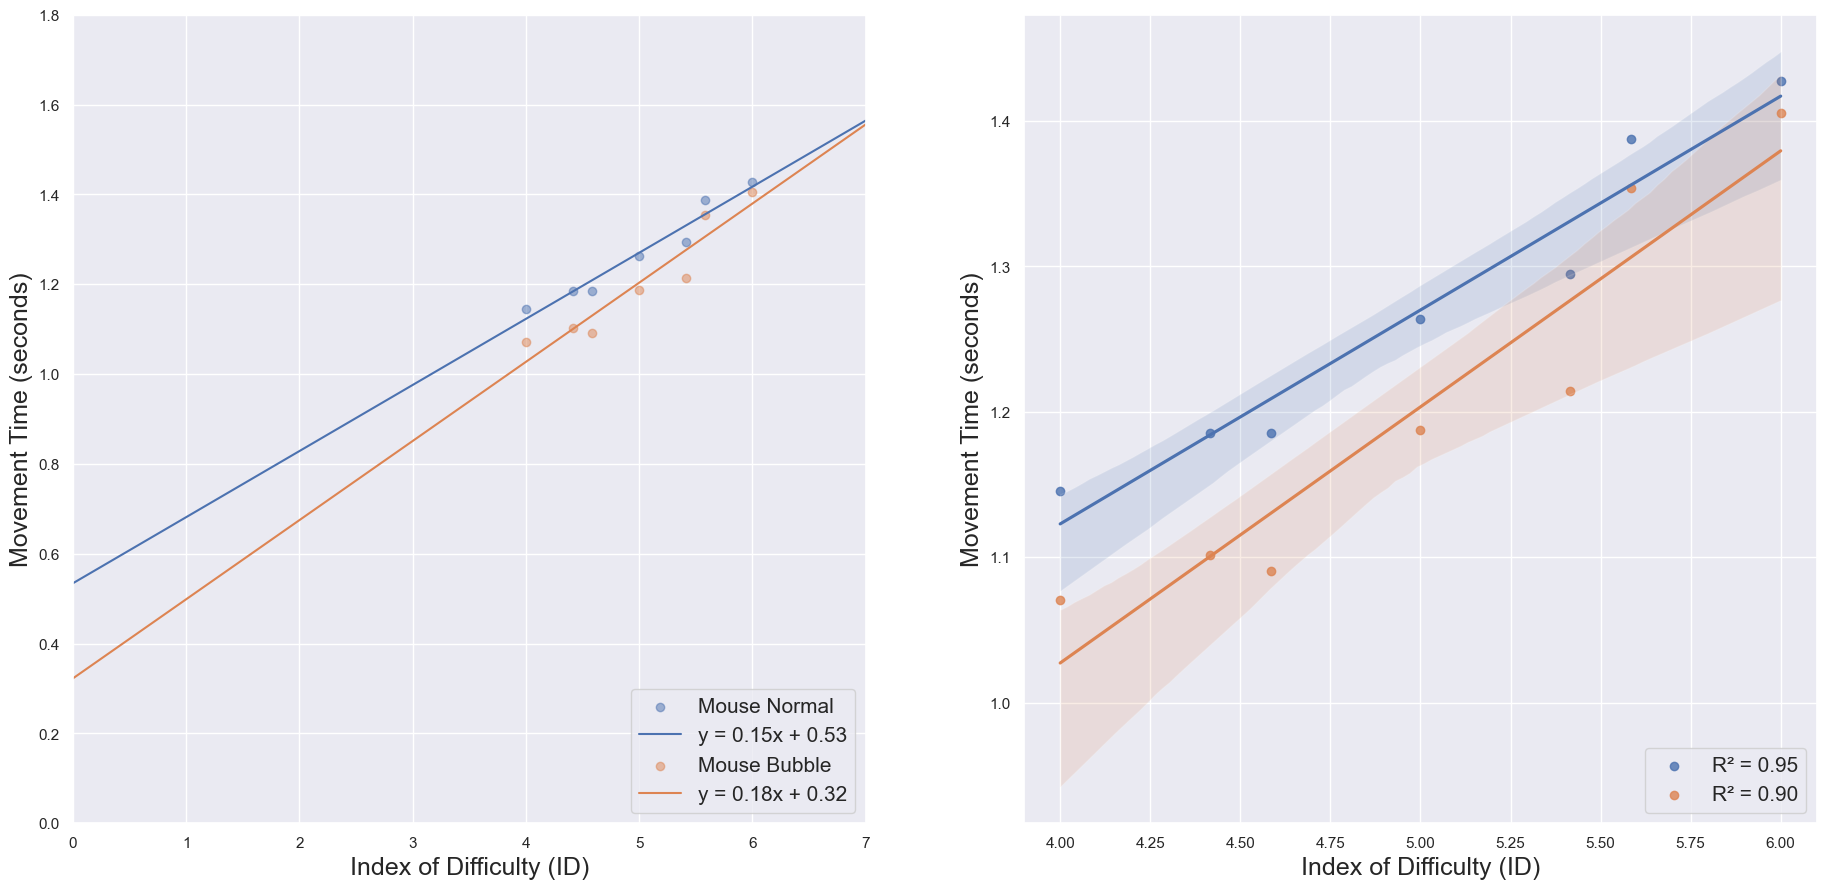

In [7]:
plot_id_mt(device=["Mouse"])

Tablet Normal r2: 0.899538421483318
Tablet Bubble r2: 0.8798705948939345


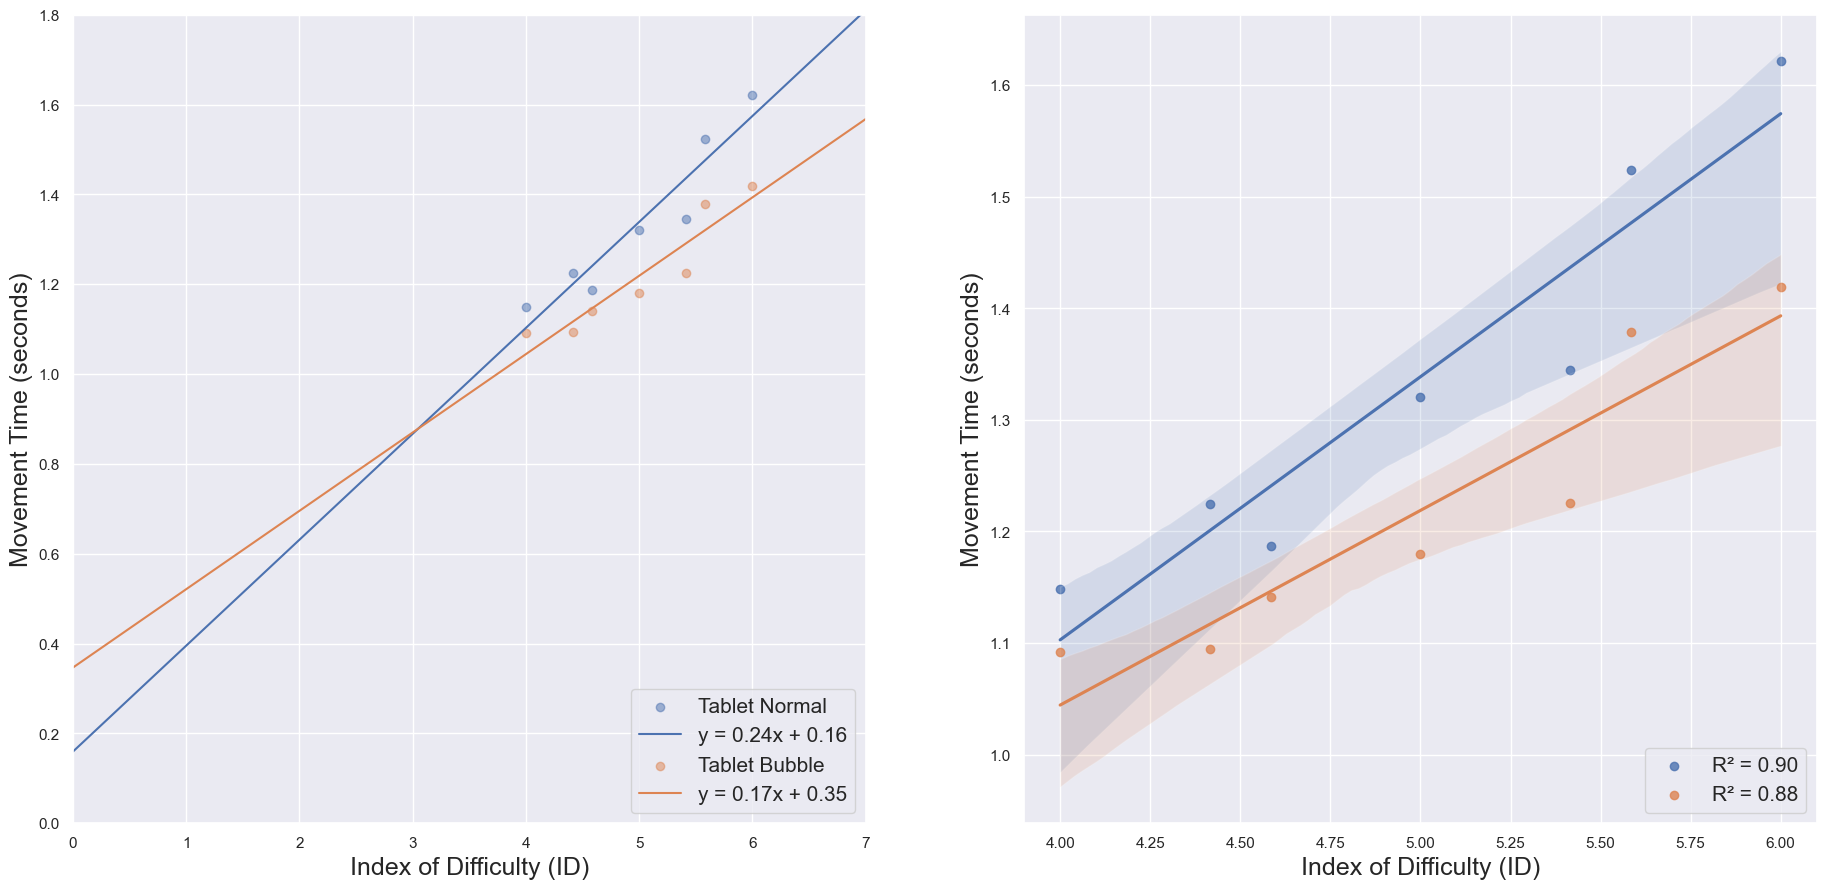

In [8]:
plot_id_mt(device=["Tablet"])

Mouse Normal r2: 0.9490356087924564
Tablet Normal r2: 0.899538421483318


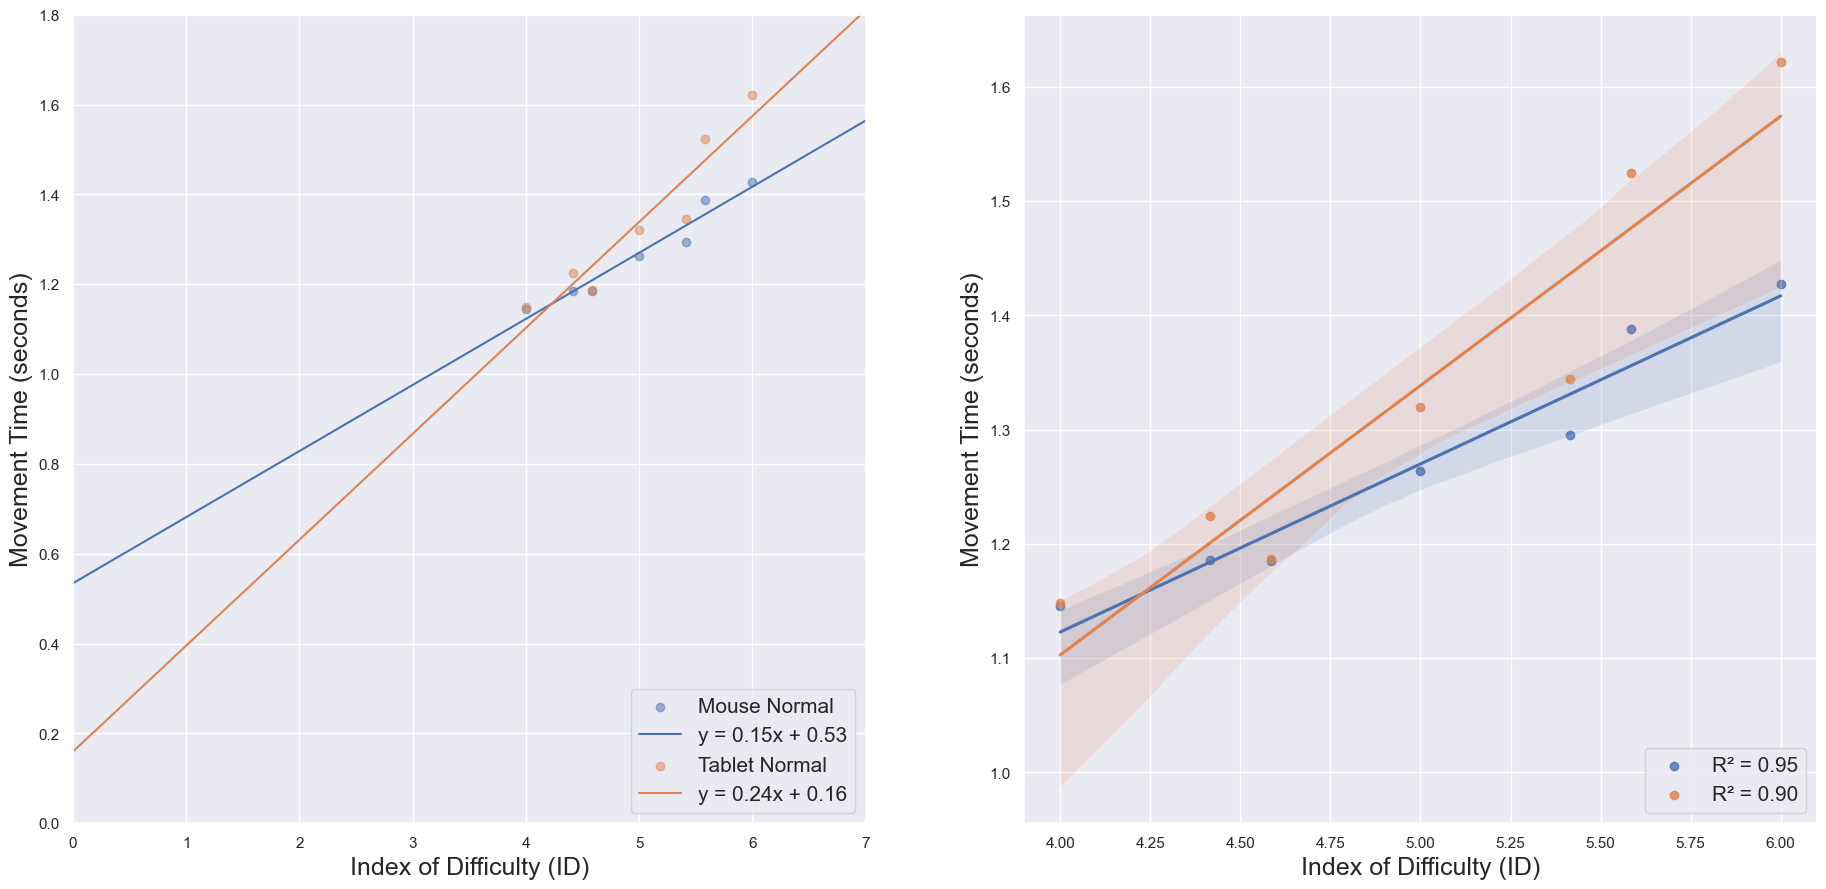

In [9]:
plot_id_mt(mode=["Normal"])

Mouse Bubble r2: 0.899465619874181
Tablet Bubble r2: 0.8798705948939345


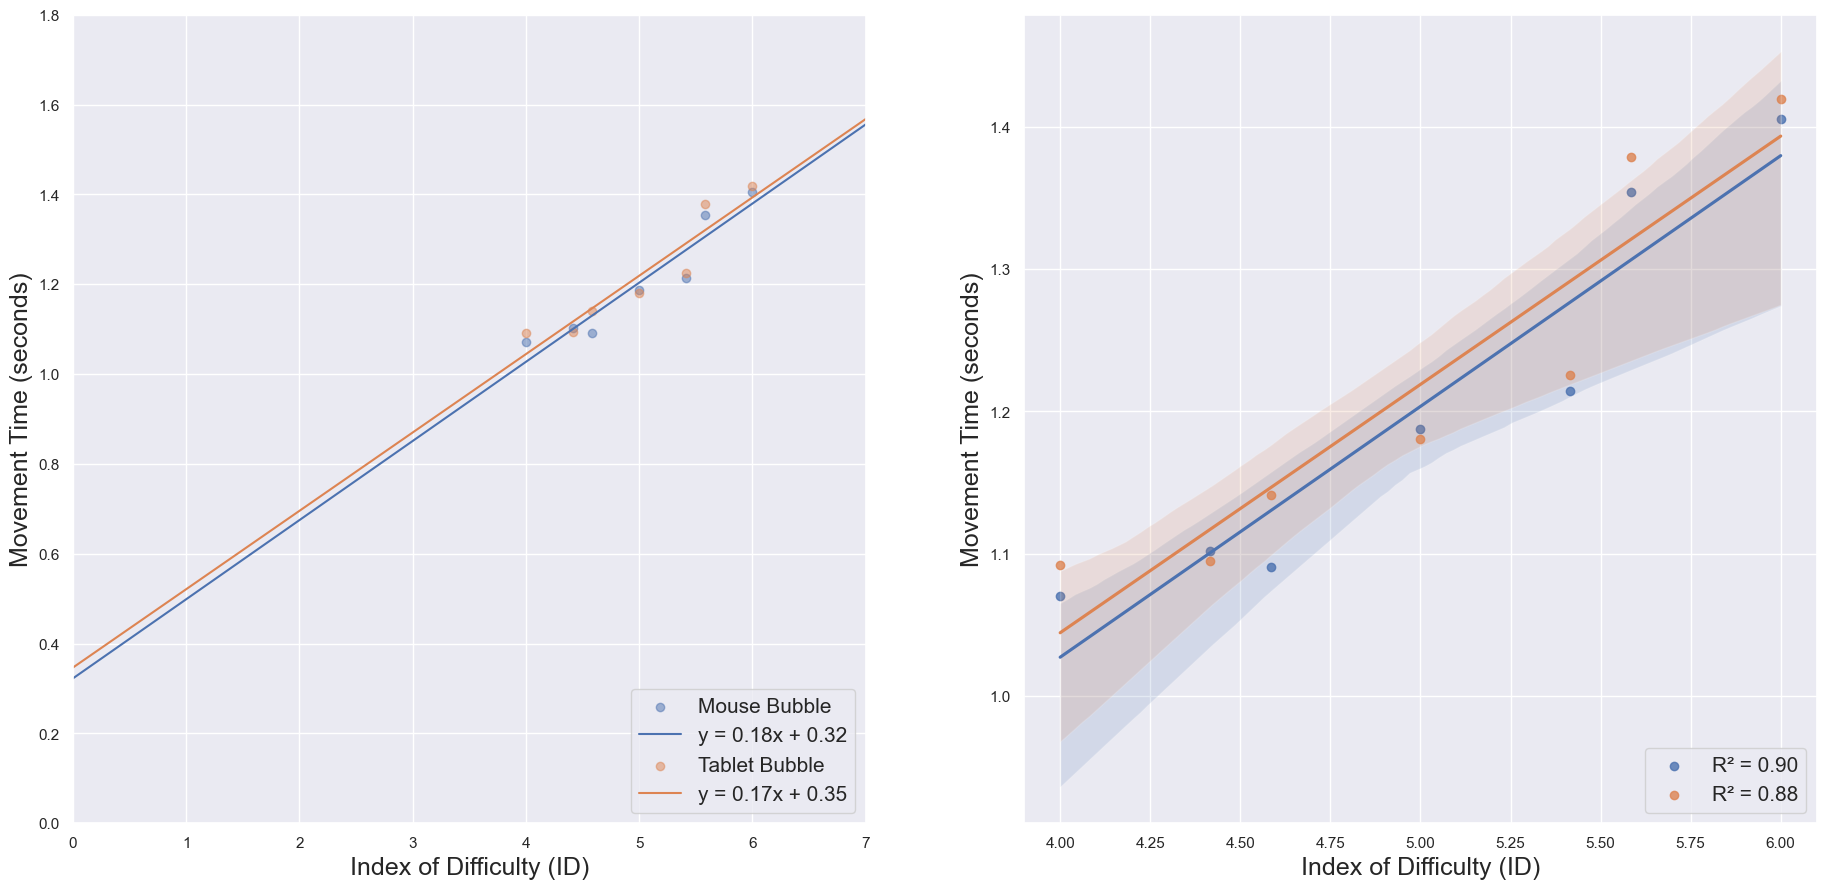

In [10]:
plot_id_mt(mode=["Bubble"])

Mouse Normal r2: 0.9490356087924564
Mouse Bubble r2: 0.899465619874181
Tablet Normal r2: 0.899538421483318
Tablet Bubble r2: 0.8798705948939345


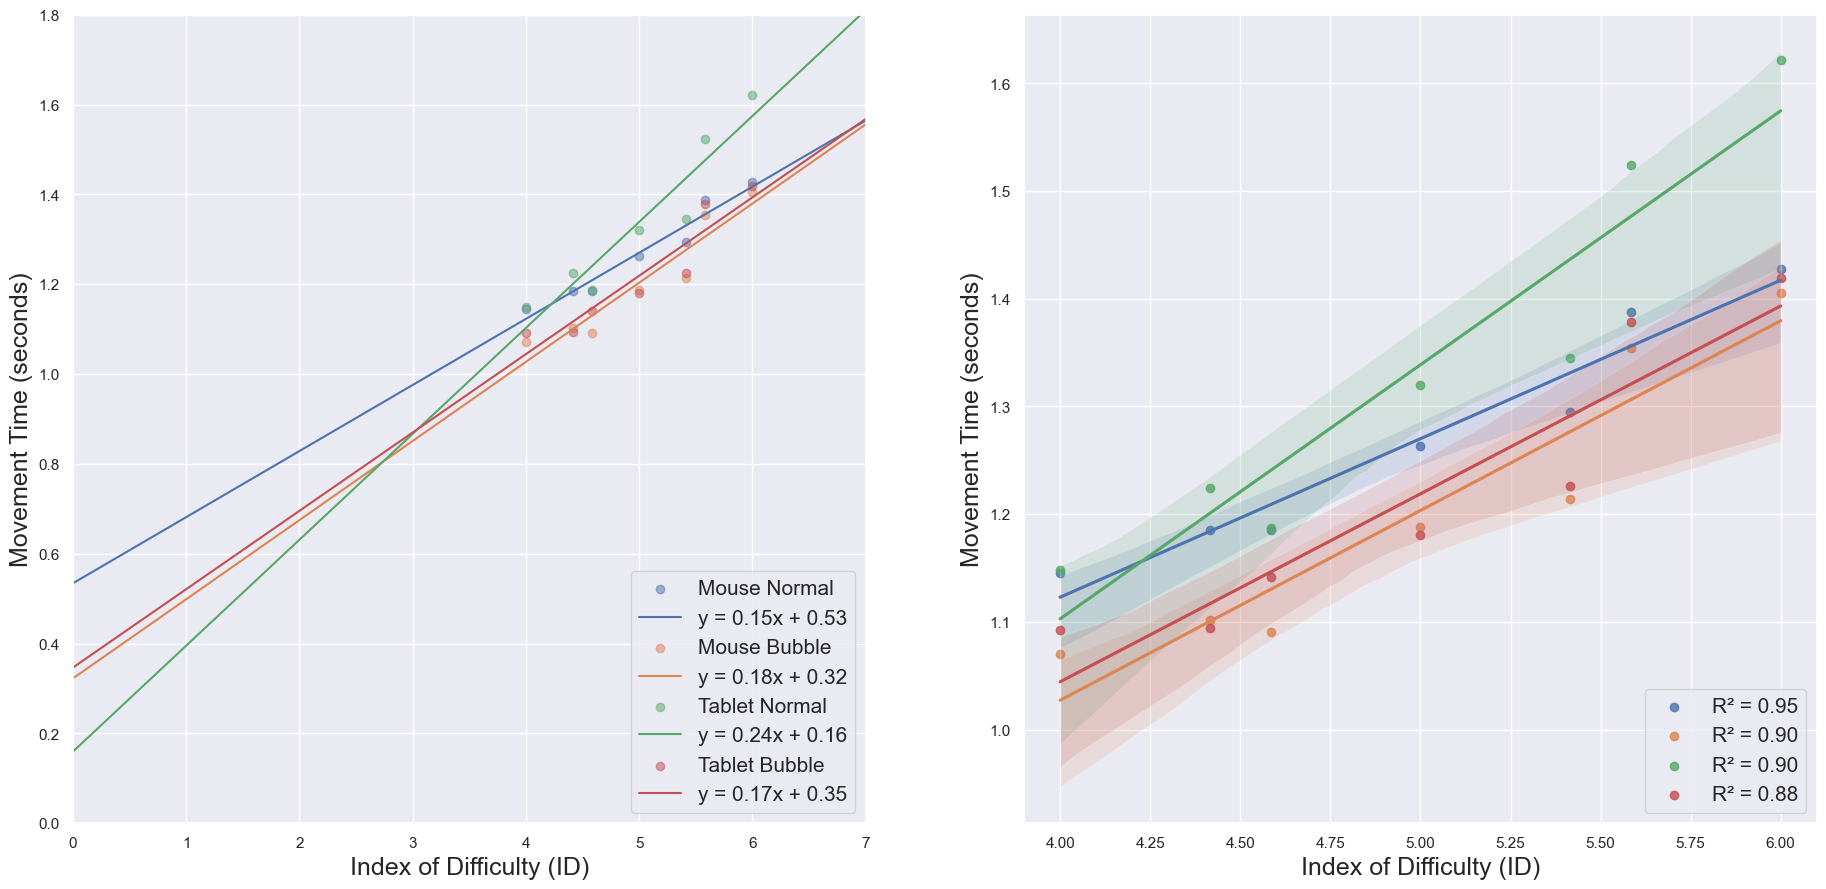

In [11]:
plot_id_mt(legend_size=9)

In [12]:
df["Input method"] = df["Device"] + " " + df["Mode"]
transformation = {
  'Tablet Bubble': 'TB',
  'Tablet Normal': 'TN',
  'Mouse Bubble': 'MB',
  'Mouse Normal': 'MN',
}
df["Input method"] = df["Input method"].replace(transformation)
df

,Name,Device,Mode,Average time,Total time,Errors,Input method
0,Haya,Mouse,Normal,1.303901,315.544,47,MN
1,Mouad,Tablet,Normal,1.099004,265.959,203,TN
2,Maria,Mouse,Bubble,1.318632,319.109,2,MB
3,Zainab,Tablet,Bubble,1.314434,318.093,29,TB
4,Alex,Tablet,Bubble,1.153112,279.053,35,TB
5,Alex,Mouse,Bubble,1.125529,272.378,3,MB
6,Gabriel,Mouse,Bubble,1.094678,264.912,3,MB
7,Mariam,Mouse,Normal,1.357169,328.435,19,MN
8,Maria,Tablet,Normal,1.720872,416.451,21,TN
9,Haya,Tablet,Normal,1.198719,290.090,71,TN


In [13]:
# stats for groups
df.groupby(["Input method"]).describe()

Average time                                                    \
                    count      mean       std       min       25%       50%   
Input method                                                                  
MB                   12.0  1.199528  0.121682  1.087525  1.121294  1.141723   
MN                   12.0  1.268181  0.065302  1.168946  1.235383  1.250583   
TB                   12.0  1.209502  0.148928  0.955058  1.109839  1.217430   
TN                   12.0  1.334138  0.186608  1.099004  1.209405  1.285326   

                                 Total time              ...             \
                   75%       max      count        mean  ...        75%   
Input method                                             ...              
MB            1.253261  1.429256       12.0  290.285833  ...  303.28925   
MN            1.296119  1.399178       12.0  306.899917  ...  313.66075   
TB            1.314477  1.477145       12.0  292.699583  ...  318.10350   
TN            1.404302  1.720872       12.0  322.861500  ...  339.84100   

                      Errors                                                  \
                  max  count       mean        std   min    25%   50%    75%   
Input method                                                                   
MB            345.880   12.0   8.666667  12.055428   1.0   2.75   4.5   9.50   
MN            338.601   12.0  25.500000  18.918485   2.0   9.00  20.0  47.25   
TB            357.469   12.0  33.166667  28.238701   6.0  16.25  27.0  38.00   
TN            416.451   12.0  69.583333  50.078953  21.0  44.50  50.5  74.50   

                     
                max  
Input method         
MB             45.0  
MN             53.0  
TB            113.0  
TN            203.0  

[4 rows x 24 columns]

<AxesSubplot: xlabel='Input method', ylabel='Errors'>

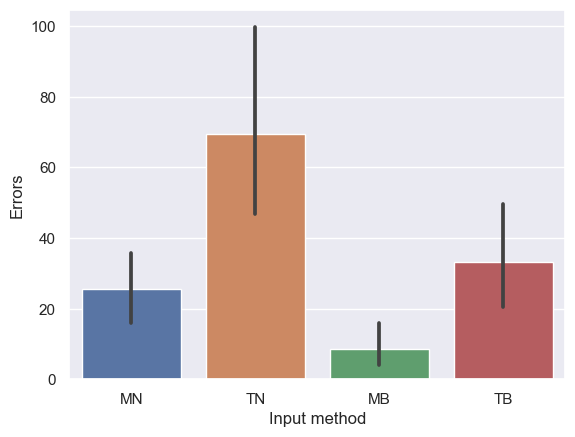

In [14]:
order = ["MN", "TN", "MB", "TB"]
sns.barplot(data=df, x="Input method", y="Errors", order=order)

<AxesSubplot: xlabel='Input method', ylabel='Average time'>

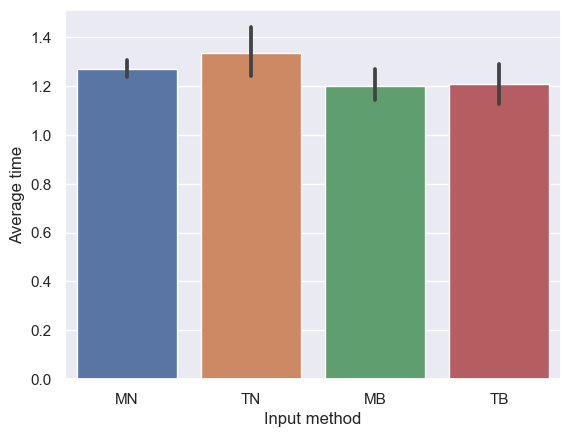

In [15]:
sns.barplot(data=df, x="Input method", y="Average time", order=order)

## 3. Time series over the four combinations

For each of the four combinations, (MN, MB, TN, TB) we will take the average results from the participants and plot them as the test progresses

In [16]:
import os 


file_names_MN = list(filter( lambda x: "mouse" in x and "normal" in x, os.listdir("./data")))
file_names_MB = list(filter( lambda x: "mouse" in x and "bubble" in x, os.listdir("./data")))
file_names_TN = list(filter( lambda x: "tablet" in x and "normal" in x, os.listdir("./data")))
file_names_TB = list(filter( lambda x: "tablet" in x and "bubble" in x, os.listdir("./data")))


In [17]:
# make a dataframe with all times for an experiment

def analysis_one_metric(column_name: str, number_of_files: int):

    df_MN = pd.DataFrame(pd.read_csv(os.path.join("data", file_names_MN[0]), skiprows=2)[column_name]) 
    df_MB = pd.DataFrame(pd.read_csv(os.path.join("data", file_names_MB[0]), skiprows=2)[column_name])
    df_TN = pd.DataFrame(pd.read_csv(os.path.join("data", file_names_TN[0]), skiprows=2)[column_name])
    df_TB = pd.DataFrame(pd.read_csv(os.path.join("data", file_names_TB[0]), skiprows=2)[column_name])

    df_MN.rename(columns={column_name: column_name + "0"}, inplace= True) 
    df_MB.rename(columns={column_name: column_name + "0"}, inplace= True) 
    df_TN.rename(columns={column_name: column_name + "0"}, inplace= True) 
    df_TB.rename(columns={column_name: column_name + "0"}, inplace= True) 

    for i in range(1,number_of_files):
        # d= pd.DataFrame(pd.read_csv(os.path.join("data", file_names[0]), skiprows=2)["clickTime"])
        # d.rename(columns={"clickTime": "clickTime{0}".format(i)}, inplace= True)
        df_MN[column_name + "{0}".format(i)] = pd.read_csv(os.path.join("data", file_names_MN[i]), skiprows=2)[column_name] 
        df_MB[column_name + "{0}".format(i)] = pd.read_csv(os.path.join("data", file_names_MB[i]), skiprows=2)[column_name] 
        df_TN[column_name + "{0}".format(i)] = pd.read_csv(os.path.join("data", file_names_TN[i]), skiprows=2)[column_name] 
        df_TB[column_name + "{0}".format(i)] = pd.read_csv(os.path.join("data", file_names_TB[i]), skiprows=2)[column_name] 

    return df_MN, df_MB, df_TN, df_TB


Text(0.5, 1.0, 'TB')

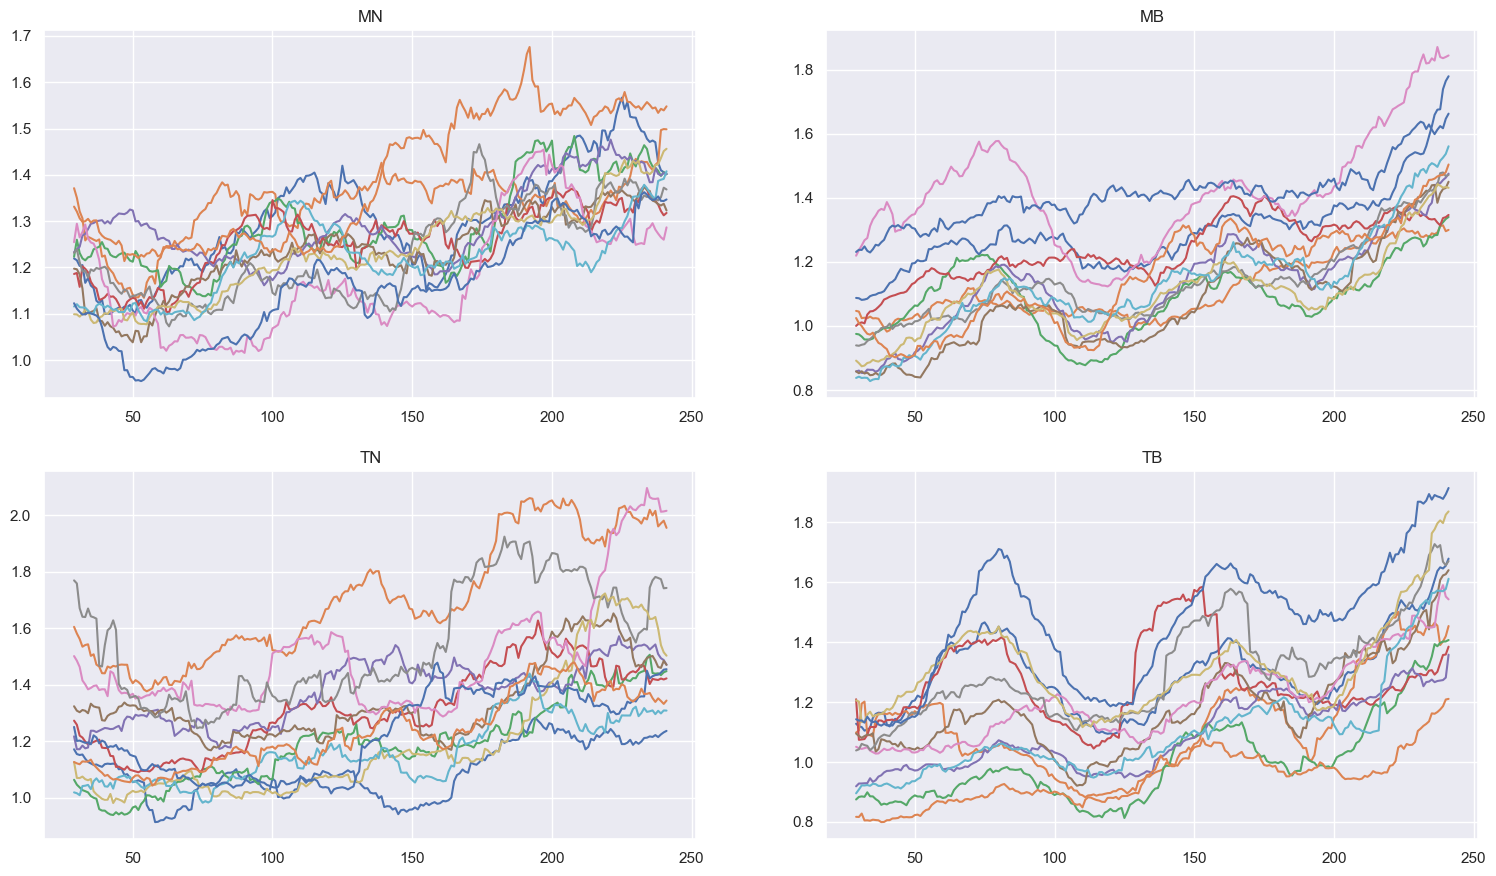

In [18]:
# Q: What happens when I print all the times of the pariticipants?
# A: A mess lol

df_times_MN, df_times_MB, df_times_TN, df_times_TB = analysis_one_metric("clickTime", len(file_names_MN))


fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

for i in range(len(file_names_MB)):
    ax[0][0].plot(df_times_MN["clickTime{0}".format(i)].rolling(30).mean()) 
    ax[0][1].plot(df_times_MB["clickTime{0}".format(i)].rolling(30).mean())
    ax[1][0].plot(df_times_TN["clickTime{0}".format(i)].rolling(30).mean())
    ax[1][1].plot(df_times_TB["clickTime{0}".format(i)].rolling(30).mean())

ax[0][0].set_title("MN")
ax[0][1].set_title("MB")
ax[1][0].set_title("TN")
ax[1][1].set_title("TB")

So plotting the data with a rolling mean highlights only the trends of the data. 
1. The normal versions do get progressively slower, as by the end the test becomes more difficult (smaller and more crowded targets)
2. The bubble versions, for both devices, have a peak in click time, then the clicktime becomes slower as the targets get more crowded   

In [19]:
# Get the mean time for experiment for all participants 

df_times_MN["meanClickTime"] = df_times_MN.mean(axis=1)
df_times_MB["meanClickTime"] = df_times_MB.mean(axis=1)
df_times_TN["meanClickTime"] = df_times_TN.mean(axis=1)
df_times_TB["meanClickTime"] = df_times_TB.mean(axis=1)

Text(0.5, 1.0, 'The mean click times for the four combinations')

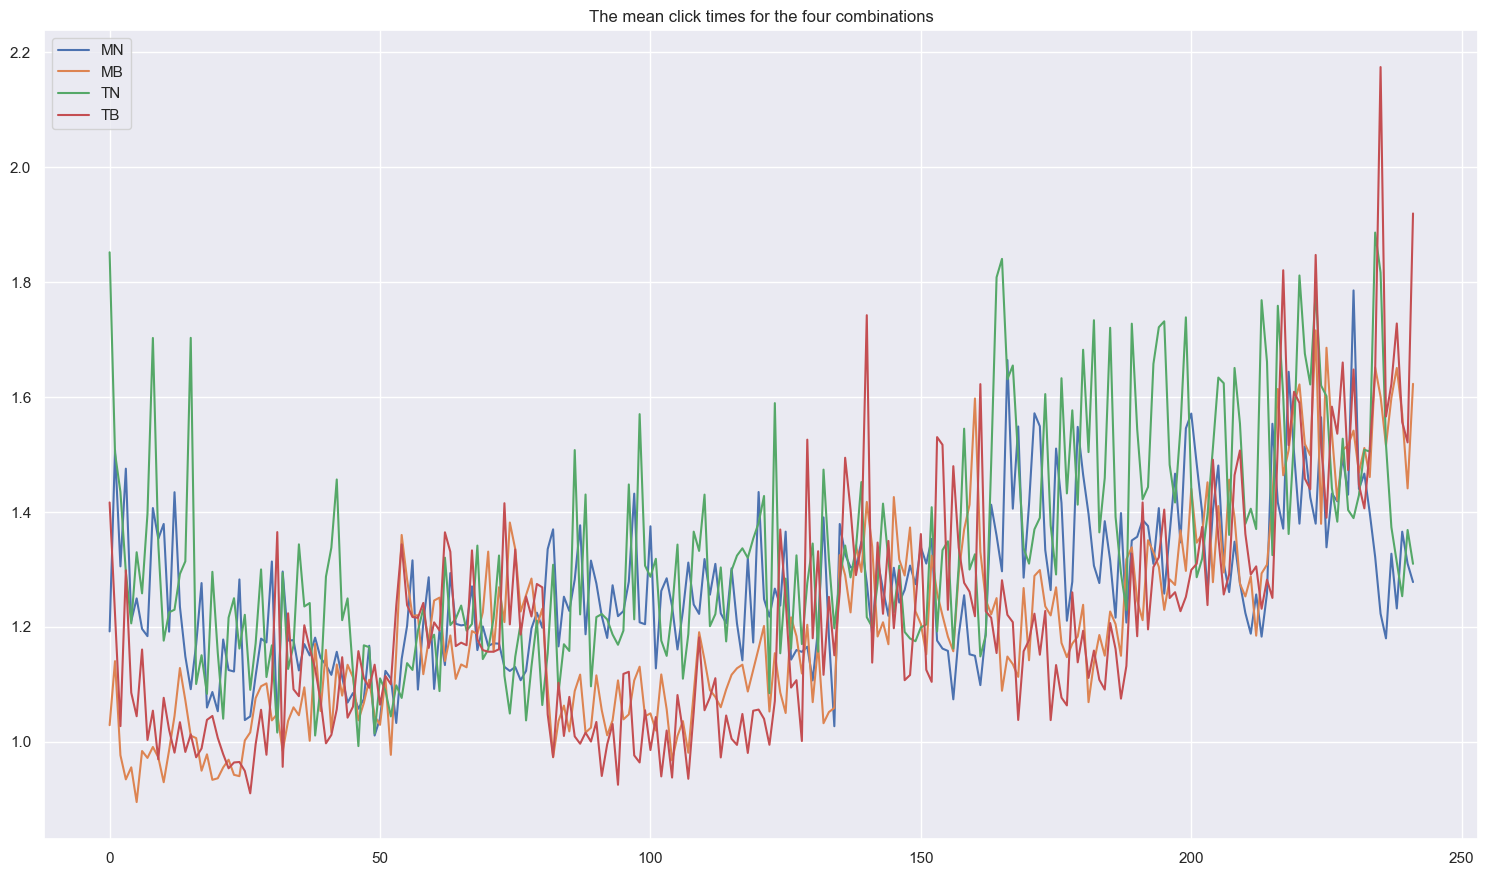

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.plot(df_times_MN["meanClickTime"], label="MN")
ax.plot(df_times_MB["meanClickTime"], label="MB")
ax.plot(df_times_TN["meanClickTime"], label="TN")
ax.plot(df_times_TB["meanClickTime"], label="TB")

ax.legend(loc="upper left")
ax.set_title("The mean click times for the four combinations")

Text(0.5, 1.0, 'The mean click times for the four combinations')

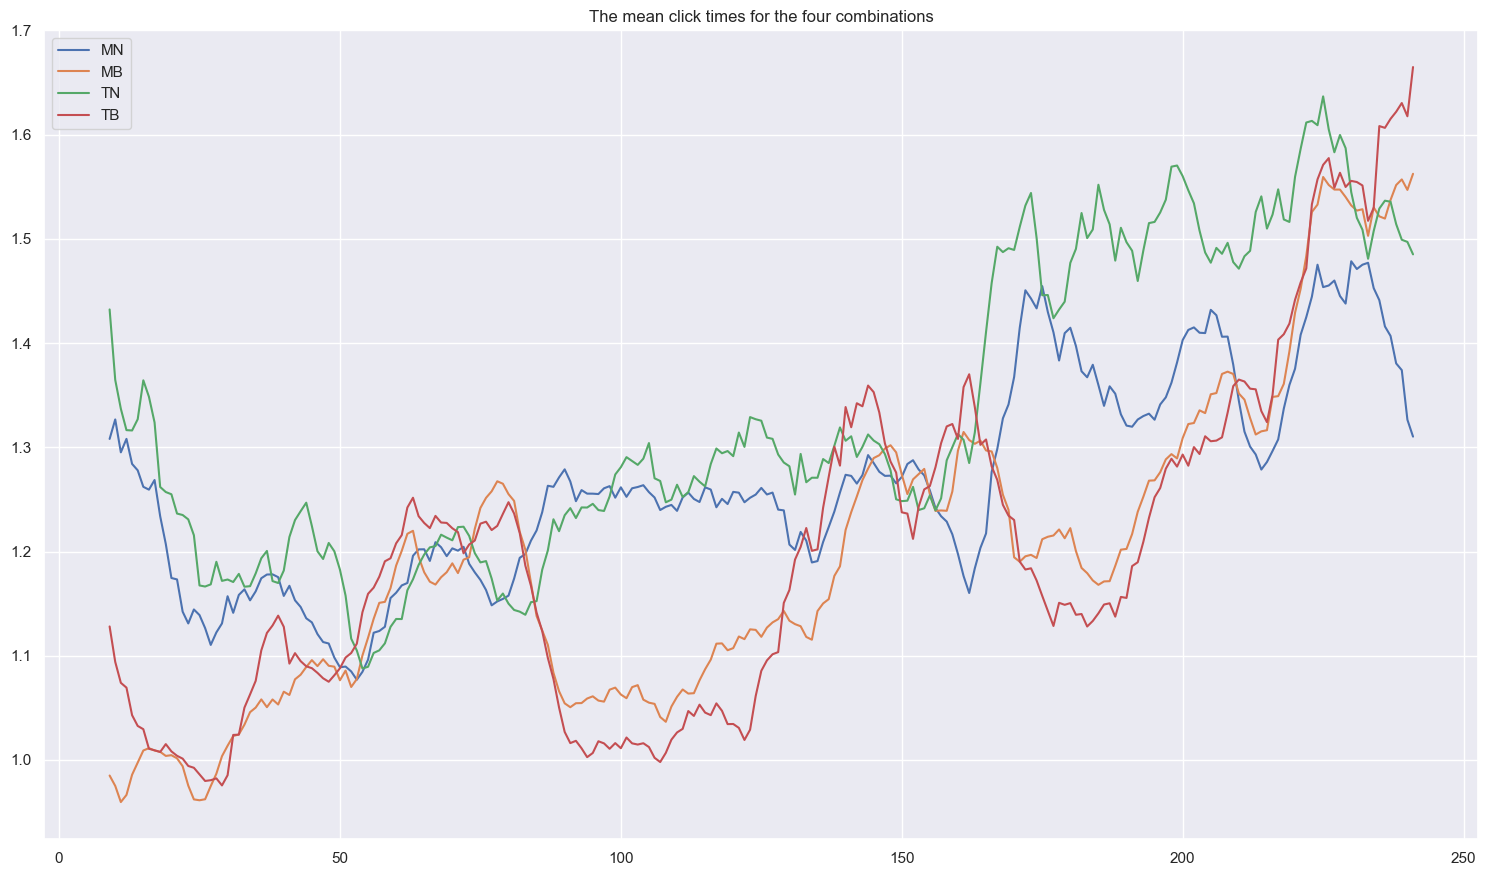

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.plot(df_times_MN["meanClickTime"].rolling(10).mean(), label="MN")
ax.plot(df_times_MB["meanClickTime"].rolling(10).mean(), label="MB")
ax.plot(df_times_TN["meanClickTime"].rolling(10).mean(), label="TN")
ax.plot(df_times_TB["meanClickTime"].rolling(10).mean(), label="TB")

ax.legend()
ax.set_title("Mean click times over round")

## 4. Same plots, but with the cumulative errors

In [22]:
df_errs_MN, df_errs_MB, df_errs_TN, df_errs_TB = analysis_one_metric("currentNumberOfErrors", len(file_names_MN));

Text(0.5, 1.0, 'TB')

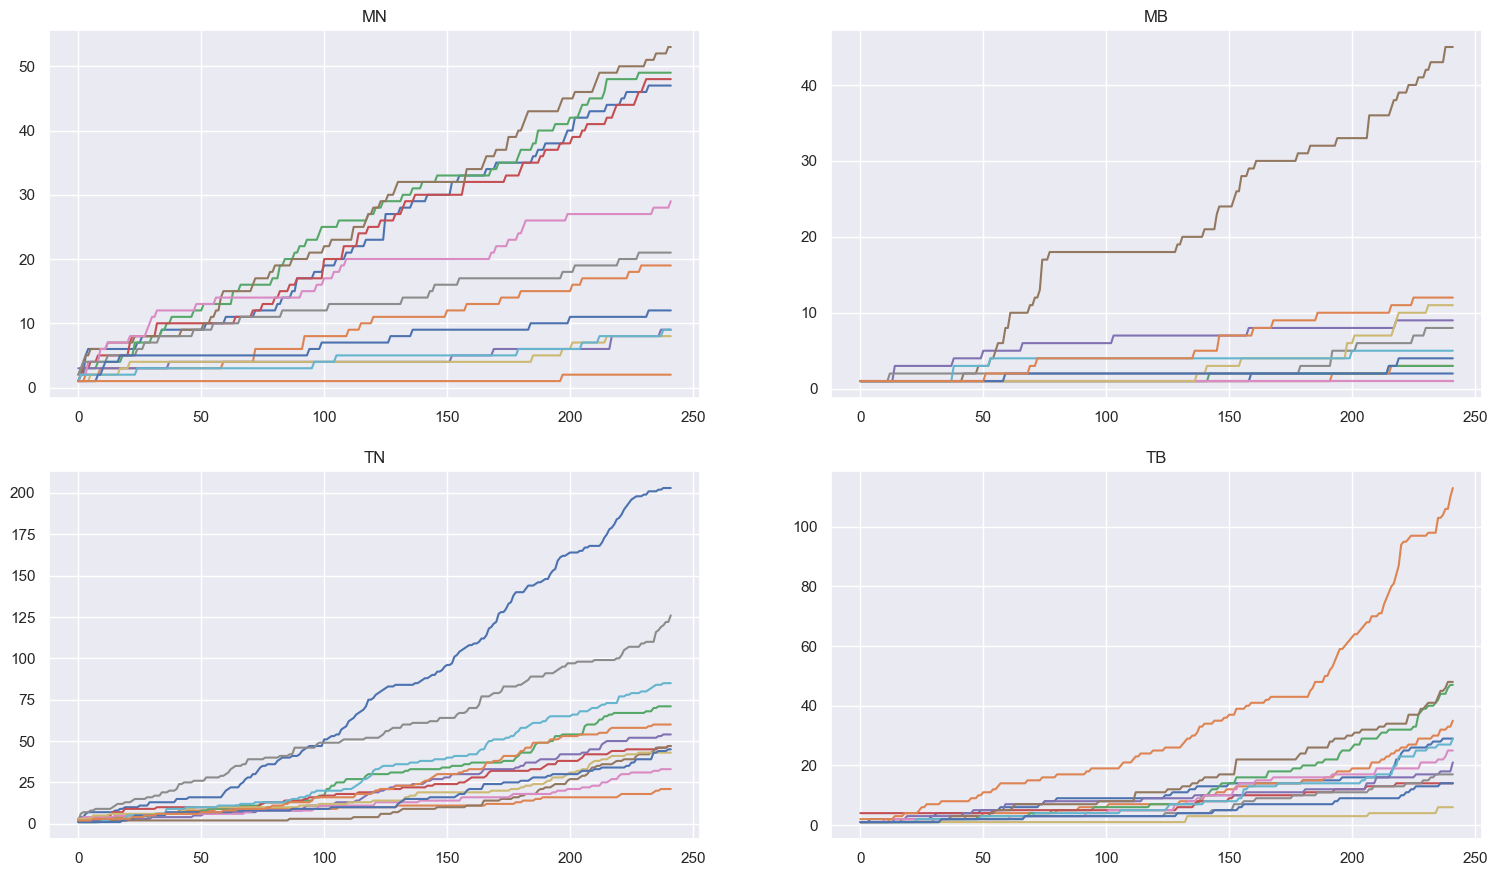

In [23]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)

for i in range(len(file_names_MB)):
    ax[0][0].plot(df_errs_MN["currentNumberOfErrors{0}".format(i)]) 
    ax[0][1].plot(df_errs_MB["currentNumberOfErrors{0}".format(i)])
    ax[1][0].plot(df_errs_TN["currentNumberOfErrors{0}".format(i)])
    ax[1][1].plot(df_errs_TB["currentNumberOfErrors{0}".format(i)])

ax[0][0].set_title("MN")
ax[0][1].set_title("MB")
ax[1][0].set_title("TN")
ax[1][1].set_title("TB")

In [24]:
df_times_MN["meanCumErr"] = df_errs_MN.mean(axis=1)
df_times_MB["meanCumErr"] = df_errs_MB.mean(axis=1)
df_times_TN["meanCumErr"] = df_errs_TN.mean(axis=1)
df_times_TB["meanCumErr"] = df_errs_TB.mean(axis=1)

Text(0.5, 1.0, 'Cumulative errors depending on input method')

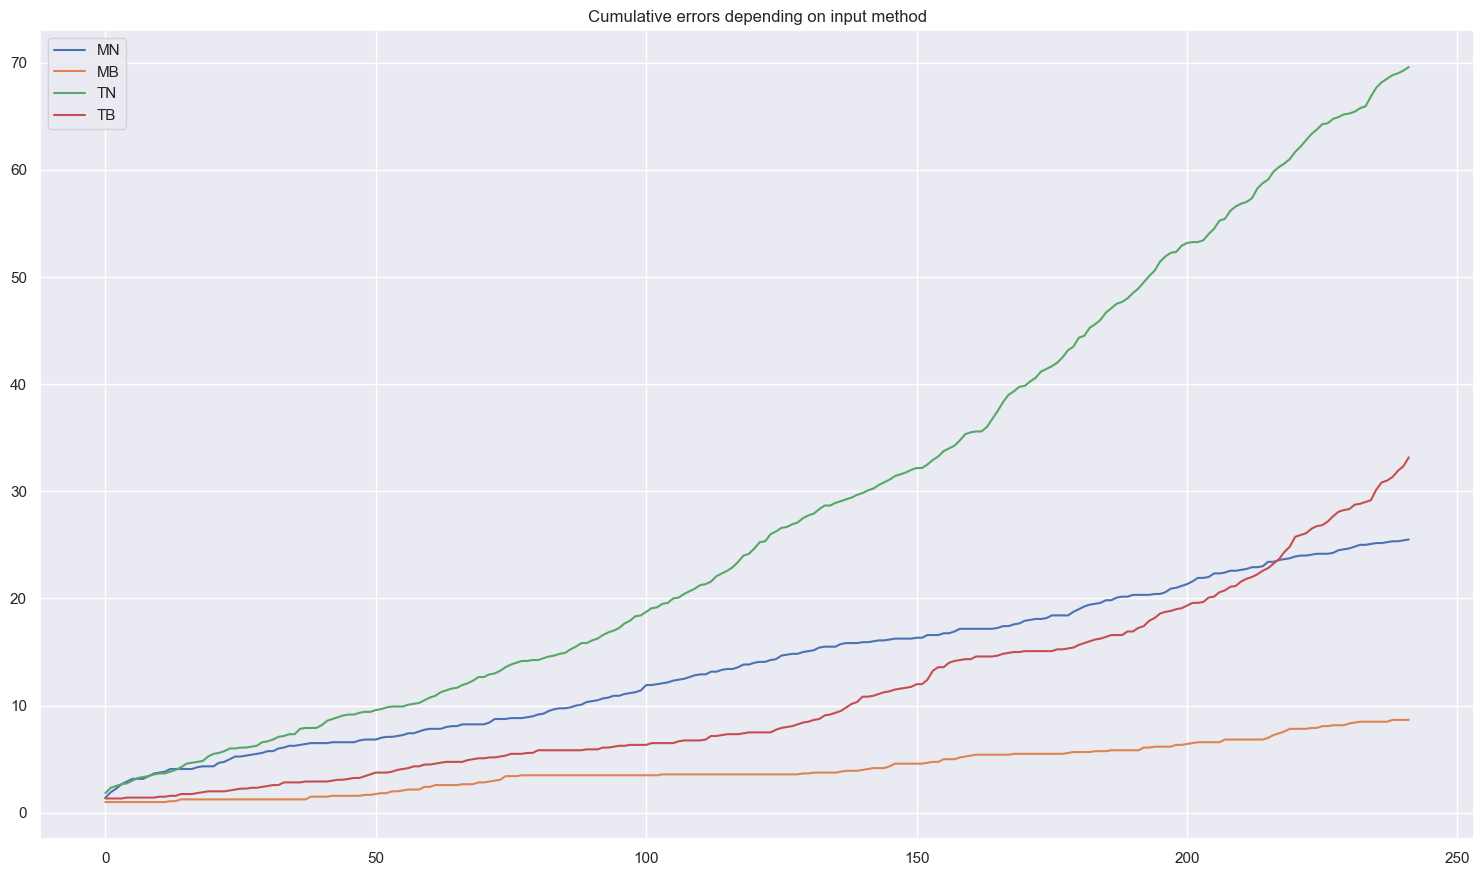

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.plot(df_times_MN["meanCumErr"], label="MN")
ax.plot(df_times_MB["meanCumErr"], label="MB")
ax.plot(df_times_TN["meanCumErr"], label="TN")
ax.plot(df_times_TB["meanCumErr"], label="TB")

ax.legend()
ax.set_title("Cumulative errors over round")

## 5. Statistical significance

### 5.1 Time on all clicks 

We want to compare the four combos: MN, MB, TN, TB using significance tests. We want to see the differences between the different treatments and how they compare. 

In [26]:
#get the distributions that we want to compare, let's get the time distributions first 

def get_all_values_of_all(file_names, column_name):

    result = np.array([])
    for f in file_names:
        result = np.append(result, pd.read_csv(os.path.join("data", f), skiprows=2)[column_name].to_numpy())

    return result


MNt = get_all_values_of_all(file_names_MN, "clickTime")
MBt = get_all_values_of_all(file_names_MB, "clickTime")
TNt = get_all_values_of_all(file_names_TN, "clickTime")
TBt = get_all_values_of_all(file_names_TB, "clickTime")

#### 5.1.1 QQ plots

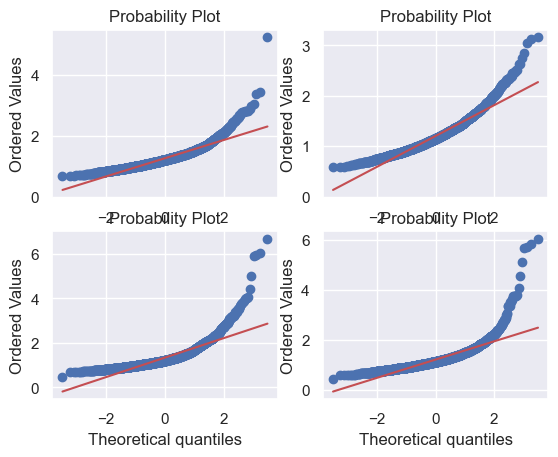

In [27]:
# do a QQ plot of the data 

import scipy.stats as stats
import matplotlib.pyplot as plt

# Create the QQ plot
fig, ax = plt.subplots(2,2)
stats.probplot(MNt, plot=ax[0][0])
stats.probplot(MBt, plot=ax[0][1])
stats.probplot(TNt, plot=ax[1][0])
stats.probplot(TBt, plot=ax[1][1])

plt.show()

From the QQ plots, we can see that the data is not normally distributed (the data does not fall in a straight line). We are going to use the wilcoxon test to see how different our distributions are 

#### 5.1.2 Wilcoxon test on the data

In [80]:
# for effect size computations, from 
# https://rcompanion.org/handbook/F_04.html , we deduced that a good way to measure the effect size for our case is by using 
# Vargha and Delaney's A
# implementation taken from https://gist.github.com/jacksonpradolima/f9b19d65b7f16603c837024d5f8c8a65 
import itertools as it

from bisect import bisect_left
from typing import List

import numpy as np
import pandas as pd
import scipy.stats as ss




def VD_A(treatment: List[float], control: List[float]):
    """
    Computes Vargha and Delaney A index
    A. Vargha and H. D. Delaney.
    A critique and improvement of the CL common language
    effect size statistics of McGraw and Wong.
    Journal of Educational and Behavioral Statistics, 25(2):101-132, 2000
    The formula to compute A has been transformed to minimize accuracy errors
    See: http://mtorchiano.wordpress.com/2014/05/19/effect-size-of-r-precision/
    :param treatment: a numeric list
    :param control: another numeric list
    :returns the value estimate and the magnitude
    """
    m = len(treatment)
    n = len(control)

    if m != n:
        raise ValueError("Data d and f must have the same length")

    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])

    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors

    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2

    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A

    return estimate, magnitude 


def call_vda(d1, d2):

    e, m = VD_A(d1.tolist(), d2.tolist())
    print("Estimate: {0}, magnitude: {1}".format(e,m))


In [68]:
from scipy.stats import wilcoxon, norm
import math

def call_stat_test(d1, d2, d1_name, d2_name, alternative = "two-sided"):

    print("The statistics for the {0} wilcoxon test between {1} and {2} is:".format(alternative, d1_name, d2_name))
    print(wilcoxon(d1,d2, alternative=alternative))
    # print(abs(norm.ppf(wilcoxon(d1,d2, alternative=alternative).pvalue/2)))
    z_value = abs(norm.ppf(wilcoxon(d1,d2, alternative=alternative).pvalue/2)) 
    effect_size = z_value/math.sqrt(d1.shape[0])
    print("Effect size: ", effect_size)
    print("================================================")

    

In [70]:
call_stat_test(MNt, MBt, "mouse normal", "mouse bubble", "greater")
call_stat_test(TNt, TBt, "tablet normal", "tablet bubble", "greater")
call_stat_test(MBt, TBt, "mouse bubble", "tablet bubble", "less")
# call_stat_test(MNt, MBt, "mouse normal", "mouse bubble", "greater")




The statistics for the greater wilcoxon test between mouse normal and mouse bubble is:
WilcoxonResult(statistic=2526690.0, pvalue=2.9795844916314047e-21)
Effect size:  0.1756107109224443
The statistics for the greater wilcoxon test between tablet normal and tablet bubble is:
WilcoxonResult(statistic=2634670.0, pvalue=5.743502806681716e-32)
Effect size:  0.2183654995613125
The statistics for the less wilcoxon test between mouse bubble and tablet bubble is:
WilcoxonResult(statistic=2178423.0, pvalue=0.9523008060803426)
Effect size:  0.001110022051471045


From these tests, it seems that we can state that MN > MB and TN > TB (as expected), however, we can't say that MB < TB, which supports our hyphotesis that the MB and TB are not that different.

In [81]:
call_vda(MNt, MBt)
call_vda(TNt, TBt)
call_vda(MBt, TBt)
call_vda(MNt, TNt)


Estimate: 0.573207777436271, magnitude: negligible
Estimate: 0.5864466177553143, magnitude: small
Estimate: 0.5168096607510112, magnitude: negligible
Estimate: 0.4985860672844144, magnitude: negligible


### 5.2 Errors 

##### 5.2.0 Process the error data

In [30]:
# here we get the cumulative sums of the errors. We can revert back to the actual number of errors made per target acquisition

MNe = get_all_values_of_all(file_names_MN, "currentNumberOfErrors")
MBe = get_all_values_of_all(file_names_MB, "currentNumberOfErrors")
TNe = get_all_values_of_all(file_names_TN, "currentNumberOfErrors")
TBe = get_all_values_of_all(file_names_TB, "currentNumberOfErrors")

In [31]:
def back_from_cumsum(array):
    
    result = [array[0]] 
    for i in range(1, len(array)):
        if array[i] < array[i-1]:
            result.append(array[i])
        else:
            result.append(array[i] - array[i-1])
            
    return np.array(result)

In [32]:
MNe_norm = back_from_cumsum(MNe)
MBe_norm = back_from_cumsum(MBe)
TNe_norm = back_from_cumsum(TNe)
TBe_norm = back_from_cumsum(TBe)

#### 5.2.1 QQ plots for our data

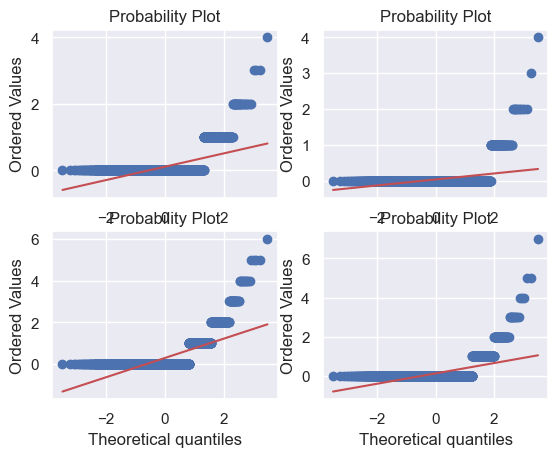

In [33]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Create the QQ plot
fig, ax = plt.subplots(2,2)
stats.probplot(MNe_norm, plot=ax[0][0])
stats.probplot(MBe_norm, plot=ax[0][1])
stats.probplot(TNe_norm, plot=ax[1][0])
stats.probplot(TBe_norm, plot=ax[1][1])

plt.show()

Ce Dumnezo ii asta

This one is not normal either. 

In [71]:
call_stat_test(MNe_norm, MBe_norm, "mouse normal", "mouse bubble", "greater")
call_stat_test(TNe_norm, TBe_norm, "mouse normal", "mouse bubble", "greater")
call_stat_test(MBe_norm, TBe_norm, "mouse normal", "mouse bubble", "less")

The statistics for the greater wilcoxon test between mouse normal and mouse bubble is:
WilcoxonResult(statistic=40363.0, pvalue=4.245588999816785e-22)
Effect size:  0.1793511697605288
The statistics for the greater wilcoxon test between mouse normal and mouse bubble is:
WilcoxonResult(statistic=218369.0, pvalue=1.8495972547915783e-26)
Effect size:  0.19752736354013484
The statistics for the less wilcoxon test between mouse normal and mouse bubble is:
WilcoxonResult(statistic=10526.0, pvalue=8.630214779996476e-30)
Effect size:  0.2103728955730774


When it comes to errors, it does look like the Tablet bubble is way more erroneous than mouse bubble. 

In [82]:
call_vda(MNe_norm, MBe_norm)
call_vda(TNe_norm, TBe_norm)
call_vda(MBe_norm, TBe_norm)
call_vda(MNe_norm, TNe_norm)

Estimate: 0.531641546949586, magnitude: negligible
Estimate: 0.5521575636151144, magnitude: negligible
Estimate: 0.4625094388665012, magnitude: negligible
Estimate: 0.44116011021181006, magnitude: negligible


## 6. Some test that we are discarding, not exactly relevant 

### other irellevant stuff

In [35]:
# run statistical significance tests

from scipy import stats 

print("P-value for KS test between mouse normal, mouse bubble: {0}".format(stats.ks_2samp(MNt, MBt).pvalue))
print("P-value for KS test between mouse bubble, tablet bubble: {0}".format(stats.ks_2samp(MBt, TBt).pvalue))
print("P-value for KS test between mouse normal, tablet normal: {0}".format(stats.ks_2samp(MNt, TNt).pvalue))
print("P-value for KS test between tablet normal, tablet bubble: {0}".format(stats.ks_2samp(TNt, TBt).pvalue))

P-value for KS test between mouse normal, mouse bubble: 2.1277957916246225e-21
P-value for KS test between mouse bubble, tablet bubble: 0.010919284479766173
P-value for KS test between mouse normal, tablet normal: 3.875332923972068e-08
P-value for KS test between tablet normal, tablet bubble: 6.828666370119194e-19


Let us look at the p-values when comparing the distributions. 
    
For all distributions, p is less than 0.05, which means that the pairs of distributions are 95% sure to be different. 
How ever (now this might be far fetched, but I will just mention), we can pe 99% sure of the statistical significance only on the first and last comparisons. 



A hyphothesis of mine was that while the bubble cursor improves the target acquisition for both the tablet and the mouse, the difference between mouse bubble and tablet bubble would not be that large. An idea to prove this was to use the KS test and see is the distributions are similar enough (failure t reject the null hyphotesis). While this was not supported by the data with 95% confidence, it could be supported if we require 99% confidence. 

In [36]:
print("P-value for ANOVA test between mouse normal, mouse bubble: {0}".format(stats.f_oneway(MNt, MBt).pvalue))
print("P-value for ANOVA test between mouse bubble, tablet bubble: {0}".format(stats.f_oneway(MBt, TBt).pvalue))
print("P-value for ANOVA test between mouse normal, tablet normal: {0}".format(stats.f_oneway(MNt, TNt).pvalue))
print("P-value for ANOVA test between tablet normal, tablet bubble: {0}".format(stats.f_oneway(TNt, TBt).pvalue))

P-value for ANOVA test between mouse normal, mouse bubble: 2.4557976403680875e-16
P-value for ANOVA test between mouse bubble, tablet bubble: 0.30996839240554624
P-value for ANOVA test between mouse normal, tablet normal: 2.339355584706819e-09
P-value for ANOVA test between tablet normal, tablet bubble: 2.2680294136217026e-24


The results of the ANOVA test are consistent with the results of the KS test (ish). It looks, from this guy, that the only group that is similar is mouse bubble and tablet bubble. 

In [37]:
# The previous test was done on similarity. Now we want a test that lets us know that the mean of a sample 
# is significantly larger than the mean of another sample. 
# For that we are using the ttest 
print("P-value for t test between mouse normal, mouse bubble, mouse normal larger: {0}".format(stats.ttest_ind(MNt, MBt, alternative="greater").pvalue))
print("P-value for t test between tablet bubble, mouse bubble, tablet bubble, larger: {0}".format(stats.ttest_ind(TBt, MBt, alternative="greater").pvalue))
print("P-value for t test between tablet normal, mouse normal,  mouse normal larger: {0}".format(stats.ttest_ind(TNt, MNt, alternative="greater").pvalue))
print("P-value for t test between tablet normal, tablet bubble, tablet normal larger: {0}".format(stats.ttest_ind(TNt, TBt, alternative="greater").pvalue))

P-value for t test between mouse normal, mouse bubble, mouse normal larger: 1.2278988201834472e-16
P-value for t test between tablet bubble, mouse bubble, tablet bubble, larger: 0.1549841962026523
P-value for t test between tablet normal, mouse normal,  mouse normal larger: 1.1696777923525311e-09
P-value for t test between tablet normal, tablet bubble, tablet normal larger: 1.134014706809958e-24


From the results, it does seem like there are differences between: 
1. mouse normal & mouse bubble: mouse normal takes longer
2. tablet normal & mouse normal: tablet normal takes longer
3. tablet normal & tablet bubble: tablet normal takes longer
However, the test does not confirm the same thing when looking at tablet bubble and mouse bubble: from the t test pov, it seems like it can't confirm that mouse normal is significantly faster than tablet normal

### 5.2 Average time per person

In [38]:
def get_averaged_values(file_names, column_name):
    
    result = [] 

    for f in file_names:
        result.append(np.mean(pd.read_csv(os.path.join("data", f), skiprows=2)[column_name].array ))
        # print(pd.read_csv(os.path.join("data", f)))

    return np.array(result)



MNt_avg = get_averaged_values(file_names_MN, "clickTime") 
MBt_avg = get_averaged_values(file_names_MB, "clickTime")
TNt_avg = get_averaged_values(file_names_TN, "clickTime")
TBt_avg = get_averaged_values(file_names_TB, "clickTime")

In [39]:
print(TNt_avg)
print(TBt_avg)

[1.09900413 1.7208719  1.19871901 1.32430992 1.3668719  1.34772727
 1.51659091 1.58321901 1.21296694 1.15840496 1.24634297 1.23463223]
[1.31443388 1.15311157 1.01967769 1.28145455 1.10060331 1.21228512
 1.22257438 1.31460744 1.35016116 1.11291735 1.47714463 0.95505785]


In [40]:
# KS test on the averages 

print("P-value for KS test between the averages of mouse normal, mouse bubble: {0}".format(stats.ks_2samp(MNt_avg, MBt_avg).pvalue))
print("P-value for KS test between the averages of mouse bubble, tablet bubble: {0}".format(stats.ks_2samp(MBt_avg, TBt_avg).pvalue))

# TODO: Why are those two values below equal ??? -- Mattis
# ANS: I have no clue (it looked weird for me too) My nugget of wisdom is that, since there are very few values, sooomehow the computations 
# gave the same values. Also, the KS test might be the wrong way to go, since it wants continuous distributions -- Ioana

 
print("P-value for KS test between the averages of mouse normal, tablet normal: {0}".format(stats.ks_2samp(MNt_avg, TNt_avg).pvalue))
print("P-value for KS test between the averages of tablet normal, tablet bubble: {0}".format(stats.ks_2samp(TBt_avg, TNt_avg).pvalue))

P-value for KS test between the averages of mouse normal, mouse bubble: 0.031436056203858066
P-value for KS test between the averages of mouse bubble, tablet bubble: 0.8689816711757754
P-value for KS test between the averages of mouse normal, tablet normal: 0.5360977695073805
P-value for KS test between the averages of tablet normal, tablet bubble: 0.5360977695073805


By comparing the averages, we can see that, with respect to time, the bubble cursor clearly changes the distribution. When comparing the mouse and the tablet, the p value suggests that the bubble changes the performance of the mouse, but the differences between the mouse and the tablet are not statistically significant. 

In [41]:
print("P-value for ANOVA test between mouse normal, mouse bubble: {0}".format(stats.f_oneway(MNt_avg, MBt_avg).pvalue))
print("P-value for ANOVA test between mouse bubble, tablet bubble: {0}".format(stats.f_oneway(MBt_avg, TBt_avg).pvalue))
print("P-value for ANOVA test between mouse normal, tablet normal: {0}".format(stats.f_oneway(MNt_avg, TNt_avg).pvalue))
print("P-value for ANOVA test between tablet normal, tablet bubble: {0}".format(stats.f_oneway(TNt_avg, TBt_avg).pvalue))

P-value for ANOVA test between mouse normal, mouse bubble: 0.09907668921248522
P-value for ANOVA test between mouse bubble, tablet bubble: 0.8590646278824182
P-value for ANOVA test between mouse normal, tablet normal: 0.2602103324112694
P-value for ANOVA test between tablet normal, tablet bubble: 0.08423782402228024


Comparing the averges gives the magical conclusion that all these things are the same. 

### 5.3 Let us look at the errors

In [42]:
# here we get the cumulative sums of the errors. We can revert back to the actual number of errors made per target acquisition

MNe = get_all_values_of_all(file_names_MN, "currentNumberOfErrors")
MBe = get_all_values_of_all(file_names_MB, "currentNumberOfErrors")
TNe = get_all_values_of_all(file_names_TN, "currentNumberOfErrors")
TBe = get_all_values_of_all(file_names_TB, "currentNumberOfErrors")

In [43]:
def back_from_cumsum(array):

    result = [array[0]] 
    for i in range(1, len(array)):
        if array[i] < array[i-1]:
            result.append(array[i])
        else:
            result.append(array[i] - array[i-1])
            
    return np.array(result)

In [44]:
MNe_norm = back_from_cumsum(MNe)
MBe_norm = back_from_cumsum(MBe)
TNe_norm = back_from_cumsum(TNe)
TBe_norm = back_from_cumsum(TBe)

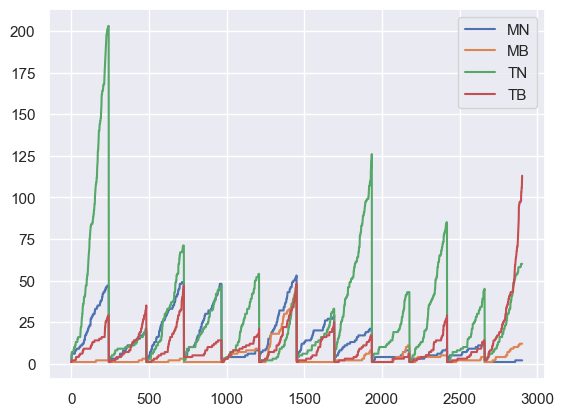

In [45]:
fig, ax = plt.subplots()

ax.plot(MNe, label = "MN")
ax.plot(MBe, label = "MB")
ax.plot(TNe, label = "TN")
ax.plot(TBe, label = "TB")


ax.legend()

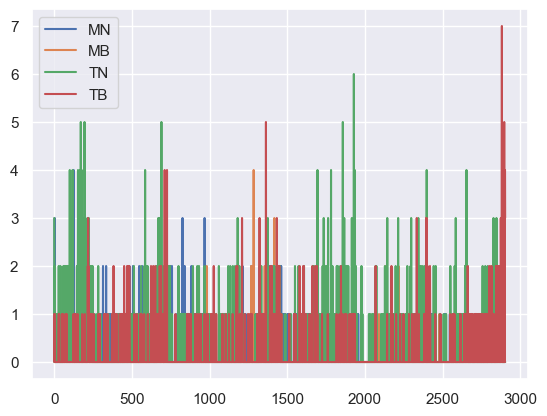

In [46]:
fig, ax = plt.subplots()

ax.plot(MNe_norm, label = "MN")
ax.plot(MBe_norm, label = "MB")
ax.plot(TNe_norm, label = "TN")
ax.plot(TBe_norm, label = "TB")

ax.legend()

This looks like a Christmas decoration lol

In [47]:
# Statistical significance things
print("P-value for the ANOVA test between mouse normal, mouse bubble: {0}".format(stats.f_oneway(MNe_norm, MBe_norm).pvalue))
print("P-value for the ANOVA test between mouse bubble, tablet bubble: {0}".format(stats.f_oneway(MBe_norm, TBe_norm).pvalue))
print("P-value for the ANOVA test between mouse normal, tablet normal: {0}".format(stats.f_oneway(MNe_norm, TNe_norm).pvalue))
print("P-value for the ANOVA test between tablet normal, tablet bubble: {0}".format(stats.f_oneway(TNe_norm, TBe_norm).pvalue))

P-value for the ANOVA test between mouse normal, mouse bubble: 5.1786548572169845e-20
P-value for the ANOVA test between mouse bubble, tablet bubble: 1.4208512442352516e-26
P-value for the ANOVA test between mouse normal, tablet normal: 2.228228437164663e-39
P-value for the ANOVA test between tablet normal, tablet bubble: 7.988135348378007e-24


All of them seem statistically different. 

### 5.4 Let us look at the total number of errors only 

In [48]:
def get_total_errors(file_names, column_name):

    result = [] 

    for f in file_names:
        result.append(max(pd.read_csv(os.path.join("data", f), skiprows=2)[column_name]))

    return np.array(result)

In [49]:
MNe_all = get_total_errors(file_names_MN, "currentNumberOfErrors") 
MBe_all = get_total_errors(file_names_MB, "currentNumberOfErrors")
TNe_all = get_total_errors(file_names_TN, "currentNumberOfErrors")
TBe_all = get_total_errors(file_names_TB, "currentNumberOfErrors")

In [50]:
TBe_all

array([ 29,  35,  47,  14,  21,  48,  25,  17,   6,  29,  14, 113])

In [51]:
# Statistical significance things
print("P-value for the ANOVA test of final values between mouse normal, mouse bubble: {0}".format(stats.f_oneway(MNe_all, MBe_all).pvalue))
print("P-value for the ANOVA test of final values between mouse bubble, tablet bubble: {0}".format(stats.f_oneway(MBe_all, TBe_all).pvalue))
print("P-value for the ANOVA test of final values between mouse normal, tablet normal: {0}".format(stats.f_oneway(MNe_all, TNe_all).pvalue))
# TODO: why is that equal to 0 -- Mattis 
print("P-value for the ANOVA test of final values between tablet normal, tablet bubble: {0}".format(stats.f_oneway(TNe_all, TBe_all).pvalue))

P-value for the ANOVA test of final values between mouse normal, mouse bubble: 0.016367490997535837
P-value for the ANOVA test of final values between mouse bubble, tablet bubble: 0.011319536124970709
P-value for the ANOVA test of final values between mouse normal, tablet normal: 0.009257414636715552
P-value for the ANOVA test of final values between tablet normal, tablet bubble: 0.03907096942638157


From the p-value, they look like statistically different distributions. 